In [9]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix

warnings.filterwarnings('ignore')

## Read test data

In [2]:
train_home_team_statistics_df = pd.read_csv('../data/test/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('../data/Train/train_away_team_statistics_df.csv', index_col=0)

train_scores = pd.read_csv('../data/Train/Y_train_1rknArQ.csv', index_col=0)


In [3]:
train_home = train_home_team_statistics_df
train_away = train_away_team_statistics_df

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan}) 


In [4]:
train_home_team_statistics_df.shape

(12303, 142)

In [5]:
train_scores.shape

(12303, 3)

## Benchmark

We try to model if HOME wins

In [6]:
train_new_y = train_scores['HOME_WINS']

# Set HOME_LEAGUE, HOME_TEAM_NAME, AWAY_LEAGUE, AWAY_TEAM_NAME to categorical
train_data['HOME_LEAGUE'] = train_data['HOME_LEAGUE'].astype('category')
train_data['HOME_TEAM_NAME'] = train_data['HOME_TEAM_NAME'].astype('category')
train_data['AWAY_LEAGUE'] = train_data['AWAY_LEAGUE'].astype('category')
train_data['AWAY_TEAM_NAME'] = train_data['AWAY_TEAM_NAME'].astype('category')

### train, test split

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_new_y, train_size=0.8, random_state=42)

### xgb model

In [22]:
params_1 = {
    'booster': 'gbtree',
    'tree_method':'hist',
    'max_depth': 8, 
    'learning_rate': 0.025,
    'objective': 'multi:softprob',
    'num_class': 2,
    'eval_metric':'mlogloss'
    }


d_train = xgb.DMatrix(X_train.replace({0:np.nan}), y_train, enable_categorical=True)
d_test = xgb.DMatrix(X_test.replace({0:np.nan}), y_test, enable_categorical=True)

num_round = 10000
evallist = [(d_train, 'train'), (d_test, 'test')]

bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)


[0]	train-mlogloss:0.68384	test-mlogloss:0.69066
[1]	train-mlogloss:0.67541	test-mlogloss:0.68825
[2]	train-mlogloss:0.66719	test-mlogloss:0.68579
[3]	train-mlogloss:0.65930	test-mlogloss:0.68374
[4]	train-mlogloss:0.65168	test-mlogloss:0.68161
[5]	train-mlogloss:0.64427	test-mlogloss:0.67993
[6]	train-mlogloss:0.63710	test-mlogloss:0.67845
[7]	train-mlogloss:0.63014	test-mlogloss:0.67726
[8]	train-mlogloss:0.62343	test-mlogloss:0.67588
[9]	train-mlogloss:0.61708	test-mlogloss:0.67450
[10]	train-mlogloss:0.61075	test-mlogloss:0.67316
[11]	train-mlogloss:0.60467	test-mlogloss:0.67200
[12]	train-mlogloss:0.59886	test-mlogloss:0.67094
[13]	train-mlogloss:0.59311	test-mlogloss:0.66989
[14]	train-mlogloss:0.58744	test-mlogloss:0.66925
[15]	train-mlogloss:0.58183	test-mlogloss:0.66866
[16]	train-mlogloss:0.57652	test-mlogloss:0.66788
[17]	train-mlogloss:0.57139	test-mlogloss:0.66735
[18]	train-mlogloss:0.56627	test-mlogloss:0.66689
[19]	train-mlogloss:0.56123	test-mlogloss:0.66640
[20]	train

### Some analysis

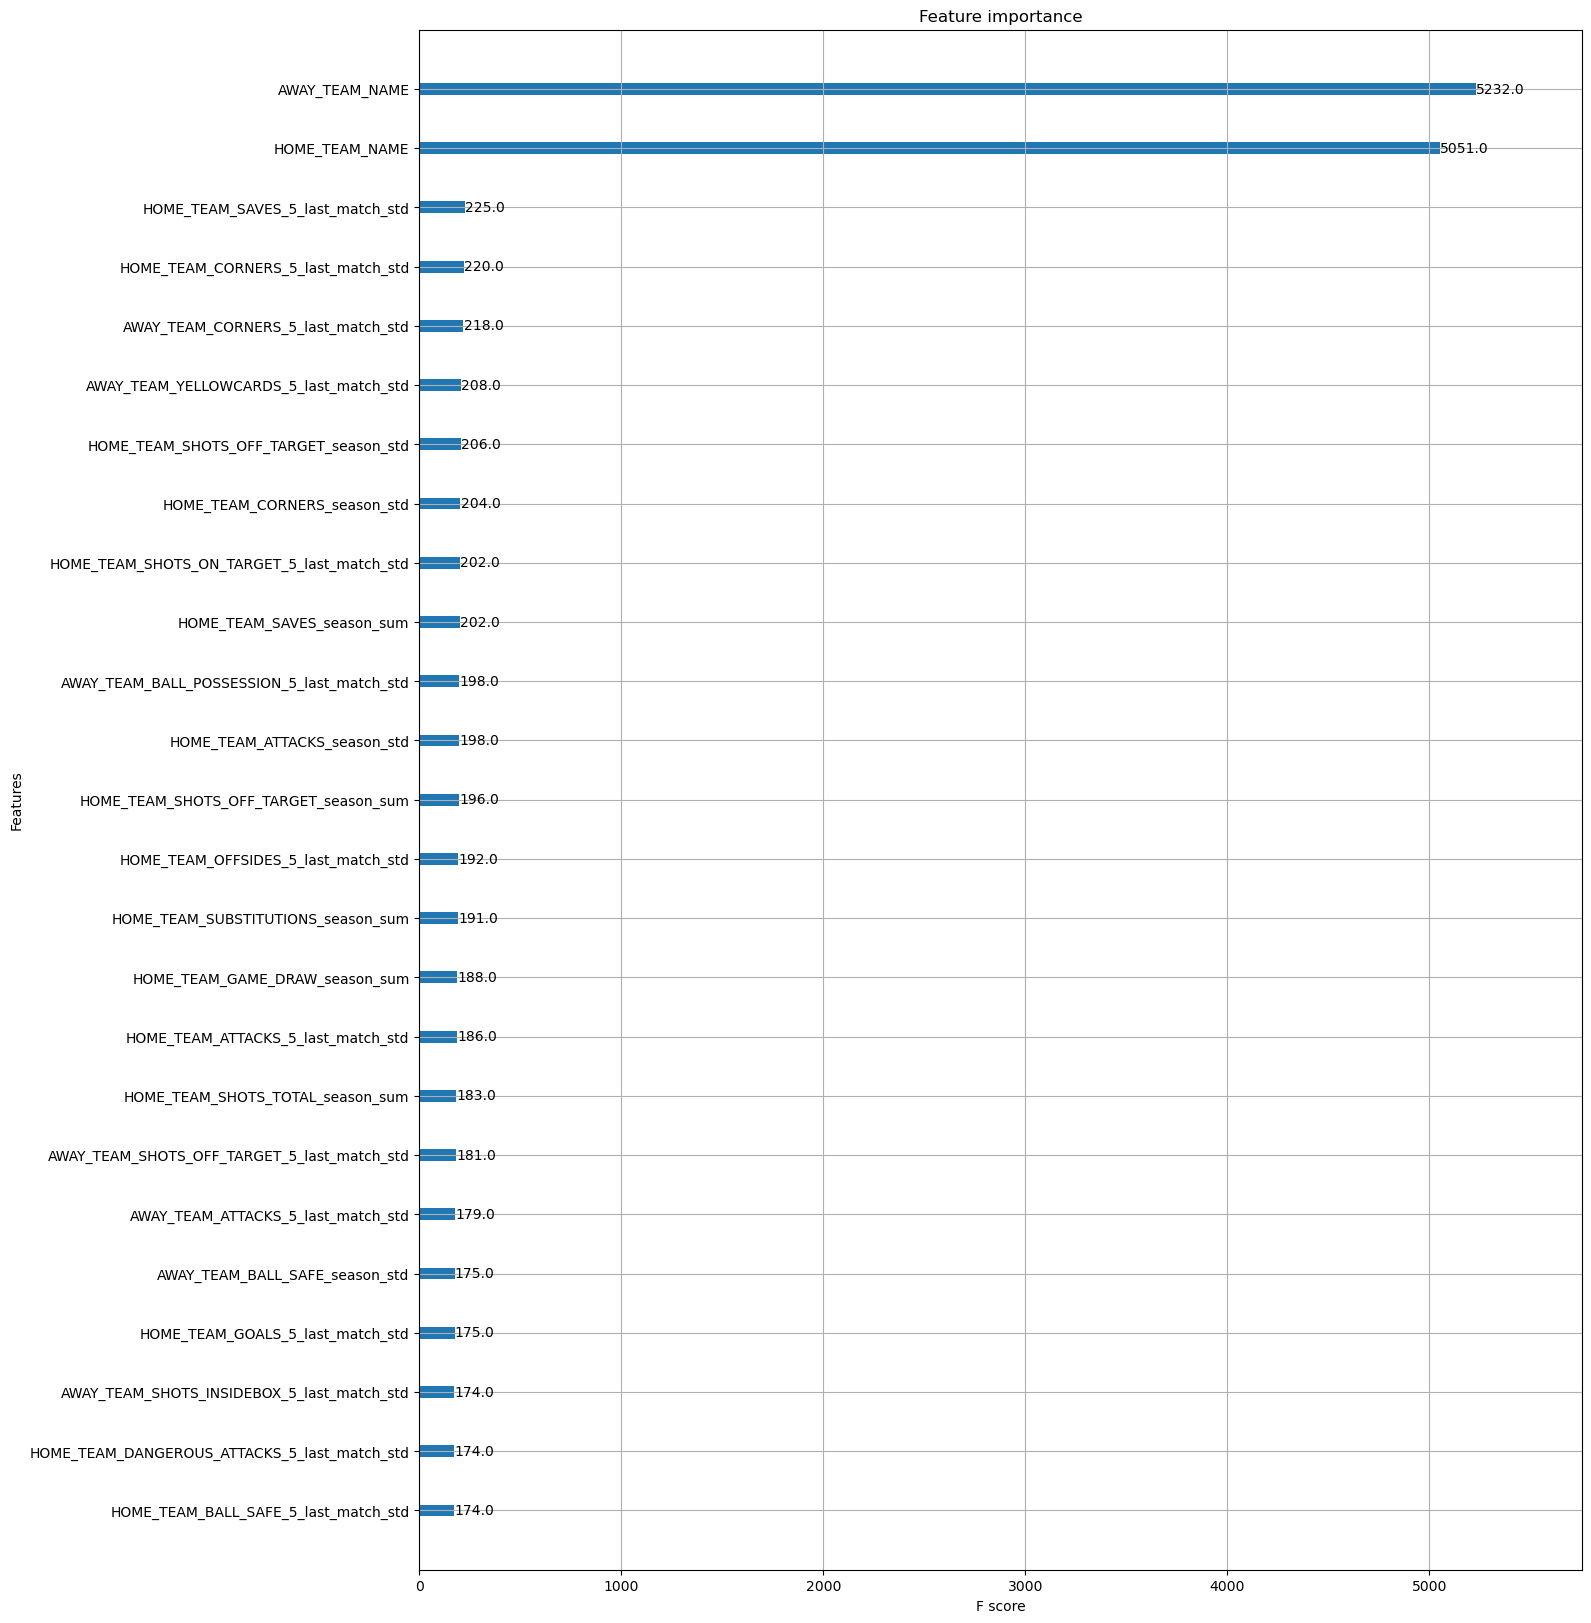

In [23]:
xgb.plot_importance(bst, max_num_features=25)
fig = plt.gcf()
fig.set_size_inches(15, 20)


### Accuracy on test set

A simple benchmark is always predicting home wins

In [24]:
target = train_scores.loc[X_test.index].copy()

home_wins = target
home_wins = 0 * home_wins
home_wins.iloc[:,0] = 1

np.round(accuracy_score(home_wins,target),4)


0.4401

Using our model

In [26]:
X_test_xgb = xgb.DMatrix(X_test, enable_categorical=True)

predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int).values
np.round(accuracy_score(predictions,target),4)


0.3174

### Try to make a simple model only on Premier League

In [31]:
mask_epl = train_home_team_statistics_df['HOME_LEAGUE'] == 'Premier League'
df_train_epl = train_home_team_statistics_df[mask_epl]

In [35]:
df_train_epl['HOME_TEAM_NAME'].value_counts()

HOME_TEAM_NAME
Wolverhampton Wanderers    33
Manchester City            33
Liverpool                  33
Everton                    33
Leicester City             32
Newcastle United           32
Burnley                    32
Manchester United          32
Southampton                32
Arsenal                    32
Chelsea                    32
Brighton & Hove Albion     32
Aston Villa                31
Tottenham Hotspur          31
Sheffield United           31
Crystal Palace             31
West Ham United            29
Watford                    16
Norwich City               16
AFC Bournemouth            16
West Bromwich Albion       15
Fulham                     15
Leeds United               11
Name: count, dtype: int64

Ok donc vu qu'on parle que des matchs à domicile, plus de 30 matchs donc doit y avoir deux saisons mais pas pour toutes les équipes, on a 6 équipes avec mois de 17 matchs donc ça doit être les relégués/promus et ya quelques valeurs manquantes pour chaque équipe.

In [36]:
df_train_epl.head()

,HOME_LEAGUE,HOME_TEAM_NAME,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,...,HOME_TEAM_YELLOWCARDS_5_last_match_std,HOME_TEAM_REDCARDS_5_last_match_std,HOME_TEAM_OFFSIDES_5_last_match_std,HOME_TEAM_ATTACKS_5_last_match_std,HOME_TEAM_PENALTIES_5_last_match_std,HOME_TEAM_SUBSTITUTIONS_5_last_match_std,HOME_TEAM_BALL_SAFE_5_last_match_std,HOME_TEAM_DANGEROUS_ATTACKS_5_last_match_std,HOME_TEAM_INJURIES_5_last_match_std,HOME_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
4,Premier League,Wolverhampton Wanderers,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,...,1.0,0.0,2.0,5.0,8.0,7.0,2.0,6.0,4.0,4.0
25,Premier League,Tottenham Hotspur,2.0,2.0,2.0,3.0,4.0,5.0,5.0,8.0,...,4.0,0.0,4.0,6.0,8.0,3.0,3.0,3.0,9.0,3.0
32,Premier League,Tottenham Hotspur,2.0,3.0,1.0,4.0,4.0,4.0,4.0,5.0,...,0.0,0.0,1.0,7.0,0.0,0.0,1.0,7.0,5.0,1.0
52,Premier League,Brighton & Hove Albion,5.0,5.0,7.0,3.0,5.0,3.0,2.0,1.0,...,1.0,0.0,6.0,0.0,10.0,4.0,10.0,5.0,5.0,2.0
53,Premier League,West Ham United,7.0,8.0,6.0,6.0,4.0,2.0,1.0,6.0,...,5.0,0.0,5.0,4.0,0.0,3.0,1.0,6.0,3.0,0.0


Sur les chiffres de la saison, par définition ils augmentent au fur et à mesure que la saison avance donc c'est pas top de capter une relation linéaire pour ça, en tout cas faut pas prendre la somme faut prendre la moyenne / moyenne sur les derniers matchs.

In [44]:
# Read all lines in pandas
pd.set_option('display.max_rows', None)
pd.DataFrame(df_train_epl.columns)

,0
0,HOME_LEAGUE
1,HOME_TEAM_NAME
2,HOME_TEAM_SHOTS_TOTAL_season_sum
3,HOME_TEAM_SHOTS_INSIDEBOX_season_sum
4,HOME_TEAM_SHOTS_OFF_TARGET_season_sum
5,HOME_TEAM_SHOTS_ON_TARGET_season_sum
6,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum
7,HOME_TEAM_PASSES_season_sum
8,HOME_TEAM_SUCCESSFUL_PASSES_season_sum
9,HOME_TEAM_SAVES_season_sum


In [48]:
mask = df_train_epl['HOME_TEAM_NAME'] == 'Manchester United'
df_train_epl[mask]['HOME_TEAM_SHOTS_INSIDEBOX_5_last_match_sum']

ID
266      2.0
980      9.0
995      4.0
1433     6.0
1885     3.0
1888     6.0
2014     3.0
2959     2.0
4940     4.0
5475     3.0
5484     6.0
6050     3.0
6603     7.0
6620     5.0
6946     3.0
7737     3.0
7951     7.0
8568     1.0
8673     8.0
8702     7.0
9019     5.0
9140     4.0
9223     5.0
9818     1.0
10409    4.0
10553    2.0
10602    5.0
10866    4.0
10908    6.0
10971    2.0
11124    4.0
11610    4.0
Name: HOME_TEAM_SHOTS_INSIDEBOX_5_last_match_sum, dtype: float64

### V2 with simpler xg boost model

## Read Train data

In [11]:
train_home_team_statistics_df = pd.read_csv('../data/Train/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('../data/Train/train_away_team_statistics_df.csv', index_col=0)

train_scores = pd.read_csv('../data/Train/Y_train_1rknArQ.csv', index_col=0)


In [12]:
train_home = train_home_team_statistics_df
train_away = train_away_team_statistics_df

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan}) 


In [13]:
train_home_team_statistics_df.shape

(12303, 142)

In [14]:
train_scores.shape

(12303, 3)

## Benchmark

We try to model if HOME wins

In [15]:
train_new_y = train_scores['HOME_WINS']

# Set HOME_LEAGUE, HOME_TEAM_NAME, AWAY_LEAGUE, AWAY_TEAM_NAME to categorical
train_data['HOME_LEAGUE'] = train_data['HOME_LEAGUE'].astype('category')
train_data['HOME_TEAM_NAME'] = train_data['HOME_TEAM_NAME'].astype('category')
train_data['AWAY_LEAGUE'] = train_data['AWAY_LEAGUE'].astype('category')
train_data['AWAY_TEAM_NAME'] = train_data['AWAY_TEAM_NAME'].astype('category')

### train, test split

In [16]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_new_y, train_size=0.8, random_state=42)

### xgb model

Accuracy: 0.6030069077610727
F1: 0.5203730976926854


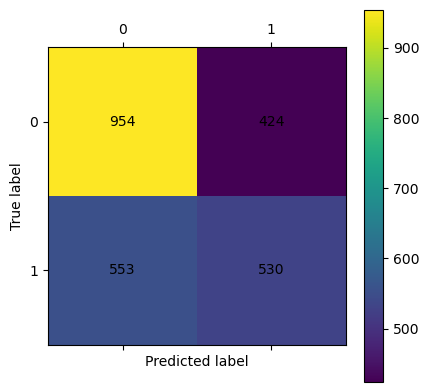

In [17]:
# Train XGBoost classifier to predict if home team wins
model = xgb.XGBClassifier(enable_categorical=True)

model.fit(X_train, y_test)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")

# Plot the confusion matrix
plt.matshow(matrix)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
# Add the numbers in the boxes
for (i, j), val in np.ndenumerate(matrix):
    plt.text(j, i, f'{val}', ha='center', va='center')
plt.show()

In [25]:
# Import the test data
test_home_team_statistics_df = pd.read_csv('../data/Test/test_home_team_statistics_df.csv', index_col=0)
test_away_team_statistics_df = pd.read_csv('../data/Test/test_away_team_statistics_df.csv', index_col=0)

In [26]:
test_home_team_statistics_df

,TEAM_SHOTS_TOTAL_season_sum,TEAM_SHOTS_INSIDEBOX_season_sum,TEAM_SHOTS_OFF_TARGET_season_sum,TEAM_SHOTS_ON_TARGET_season_sum,TEAM_SHOTS_OUTSIDEBOX_season_sum,TEAM_PASSES_season_sum,TEAM_SUCCESSFUL_PASSES_season_sum,TEAM_SAVES_season_sum,TEAM_CORNERS_season_sum,TEAM_FOULS_season_sum,...,TEAM_YELLOWCARDS_5_last_match_std,TEAM_REDCARDS_5_last_match_std,TEAM_OFFSIDES_5_last_match_std,TEAM_ATTACKS_5_last_match_std,TEAM_PENALTIES_5_last_match_std,TEAM_SUBSTITUTIONS_5_last_match_std,TEAM_BALL_SAFE_5_last_match_std,TEAM_DANGEROUS_ATTACKS_5_last_match_std,TEAM_INJURIES_5_last_match_std,TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
12303,3.0,6.0,5.0,1.0,3.0,9.0,8.0,10.0,6.0,7.0,...,2.0,9.0,0.0,10.0,0.0,4.0,4.0,6.0,2.0,3.0
12304,3.0,2.0,4.0,2.0,6.0,1.0,1.0,2.0,4.0,10.0,...,9.0,10.0,3.0,1.0,8.0,3.0,8.0,1.0,0.0,2.0
12305,7.0,10.0,8.0,8.0,1.0,4.0,5.0,0.0,10.0,4.0,...,6.0,8.0,2.0,9.0,0.0,6.0,0.0,9.0,NaN,0.0
12306,5.0,7.0,5.0,9.0,5.0,7.0,6.0,3.0,5.0,8.0,...,4.0,5.0,2.0,3.0,8.0,0.0,2.0,2.0,2.0,3.0
12307,5.0,4.0,6.0,3.0,5.0,0.0,0.0,2.0,2.0,9.0,...,5.0,0.0,0.0,7.0,5.0,0.0,1.0,6.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37666,5.0,5.0,5.0,5.0,7.0,6.0,6.0,4.0,6.0,8.0,...,2.0,6.0,2.0,1.0,5.0,6.0,6.0,5.0,2.0,0.0
37667,5.0,5.0,2.0,8.0,3.0,7.0,7.0,2.0,2.0,2.0,...,3.0,0.0,2.0,8.0,0.0,0.0,4.0,8.0,10.0,10.0
37668,10.0,10.0,10.0,8.0,8.0,5.0,5.0,2.0,6.0,0.0,...,7.0,0.0,8.0,4.0,0.0,7.0,NaN,2.0,NaN,3.0


Ah mais en fait ya pas les données LEAGUE et TEAM dans les données de test donc on peut pas les inclure dans le train...

In [20]:
test_home = test_home_team_statistics_df
test_away = test_away_team_statistics_df

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

test_data =  pd.concat([test_home,test_away],join='inner',axis=1)

test_data = test_data.replace({np.inf:np.nan,-np.inf:np.nan}) 


In [21]:
test_home_team_statistics_df.shape

(25368, 140)

## Benchmark

We try to model if HOME wins

In [22]:
# Set HOME_LEAGUE, HOME_TEAM_NAME, AWAY_LEAGUE, AWAY_TEAM_NAME to categorical
test_data['HOME_LEAGUE'] = test_data['HOME_LEAGUE'].astype('category')
test_data['HOME_TEAM_NAME'] = test_data['HOME_TEAM_NAME'].astype('category')
test_data['AWAY_LEAGUE'] = test_data['AWAY_LEAGUE'].astype('category')
test_data['AWAY_TEAM_NAME'] = test_data['AWAY_TEAM_NAME'].astype('category')

KeyError: 'HOME_LEAGUE'

### train, test split

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_new_y, train_size=0.8, random_state=42)

### xgb model

Accuracy: 0.6030069077610727
F1: 0.5203730976926854


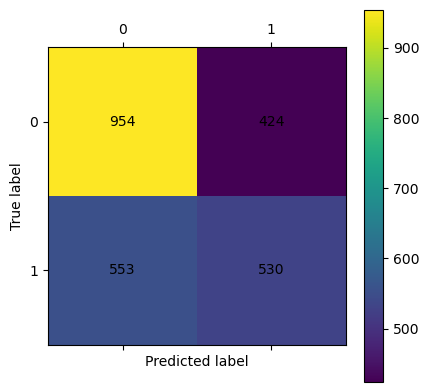

In [ ]:
# Train XGBoost classifier to predict if home team wins
model = xgb.XGBClassifier(enable_categorical=True)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")

# Plot the confusion matrix
plt.matshow(matrix)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
# Add the numbers in the boxes
for (i, j), val in np.ndenumerate(matrix):
    plt.text(j, i, f'{val}', ha='center', va='center')
plt.show()